In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import os

import tensorflow as tf
from tensorflow.models.rnn import rnn_cell
from tensorflow.models.rnn import seq2seq

## Build deep recurrent model with MDN densecap

In [2]:
generate = True
hidden = 128
nlayers = 2
dropout_keep = 0.8
tsteps = 1

batch_size = 1
nmixtures = 20
num_epochs = 30

save_every =100
grad_clip = 10.
learning_rate = 0.01
decay_rate = .95

data_scale=0.1

In [3]:
cell_func = rnn_cell.BasicLSTMCell
cell0 = cell_func(hidden)
cell1 = cell_func(hidden)
# cells = rnn_cell.MultiRNNCell(cell_list)

if (generate == False and dropout_keep < 1): # training mode
    cell0 = rnn_cell.DropoutWrapper(cell0, output_keep_prob = dropout_keep)
    cell1 = rnn_cell.DropoutWrapper(cell1, output_keep_prob = dropout_keep)

input_data = tf.placeholder(dtype=tf.float32, shape=[None, tsteps, 3])
target_data = tf.placeholder(dtype=tf.float32, shape=[None, tsteps, 3])
istate_cell0 = cell0.zero_state(batch_size=batch_size, dtype=tf.float32)
istate_cell1 = cell1.zero_state(batch_size=batch_size, dtype=tf.float32)

In [4]:
n_out = 1 + nmixtures * 6 # end_of_stroke + gaussian mixtures defining stroke locations
#put a mixture density network (mdn) cap on top of the rnn cells
with tf.variable_scope('rnn_root'):
    output_w = tf.get_variable("output_w", [hidden, n_out])
    output_b = tf.get_variable("output_b", [n_out])

#slice the input volume into separate vols for each tstep
inputs = [tf.squeeze(input_, [1]) for input_ in tf.split(1, tsteps, input_data)]

#build cell0 computational graph
outputs, pstate_cell0 = seq2seq.rnn_decoder(inputs, istate_cell0, cell0, loop_function=None, scope='cell0')

#build cell1 computational graph
outputs, pstate_cell1 = seq2seq.rnn_decoder(outputs, istate_cell1, cell1, loop_function=None, scope='cell1')

#put dense cap on top of cell1
output = tf.reshape(tf.concat(1, outputs), [-1, hidden]) #concat outputs before sending them through mdn cap
output = tf.nn.xw_plus_b(output, output_w, output_b) #data flows through mdn

A 2D gaussian looks like
$\mathcal{N}(x|\mu,\sigma,\rho)=\frac{1}{2\pi\sigma_1\sigma_2\sqrt(1-\rho^2)}exp\left[\frac{-Z}{2(1-\rho^2)}\right]$ where $Z=\frac{(x_1-\mu_1)^2}{\sigma_1^2}+\frac{(x_2-\mu_2)^2}{\sigma_2^2}-\frac{2\rho(x_1-\mu_1)(x_2-\mu_2)}{\sigma_1\sigma_2}$

In [5]:
def gaussian2d(x1, x2, mu1, mu2, s1, s2, rho):
    # define gaussian mdn (eq 24, 25 from http://arxiv.org/abs/1308.0850)
    x_mu1 = tf.sub(x1, mu1)
    x_mu2 = tf.sub(x2, mu2)
    Z = tf.square(tf.div(x_mu1, s1)) + \
        tf.square(tf.div(x_mu2, s2)) - \
        2*tf.div(tf.mul(rho, tf.mul(x_mu1, x_mu2)), tf.mul(s1, s2))
    rho_square_term = 1-tf.square(rho)
    power_e = tf.exp(tf.div(-Z,2*rho_square_term))
    regularize_term = 2*np.pi*tf.mul(tf.mul(s1, s2), tf.sqrt(rho_square_term))
    gaussian = tf.div(power_e, regularize_term)
    return gaussian

Given the mdn cap, our loss function becomes 
$$ \mathcal{L}(x)=\sum_{t=1}^{T} -log\left(\sum_{j} \pi_t^j\mathcal{N}(x_{t+1}|\mu_t^j,\sigma_t^j,\rho_t^j)
\right)
-\left\{
        \begin{array}{ll}
            \log e_t & (x_{t+1})_3=1\\
            \log(1-e_t) & \quad \mathrm{otherwise}
        \end{array}
    \right.
$$

In [6]:
def get_loss(pi, x1_data, x2_data, eos_data, mu1, mu2, sigma1, sigma2, rho, eos):
    # define loss function (eq 26 of http://arxiv.org/abs/1308.0850)
    gaussian = gaussian2d(x1_data, x2_data, mu1, mu2, sigma1, sigma2, rho)
    term1 = tf.mul(gaussian, pi)
    term1 = tf.reduce_sum(term1, 1, keep_dims=True) #do inner summation
    term1 = -tf.log(tf.maximum(term1, 1e-20)) # some errors are zero -> numerical errors.

    term2 = tf.mul(eos, eos_data) + tf.mul(1-eos, 1-eos_data) #modified Bernoulli -> eos probability
    term2 = -tf.log(term2) #negative log error gives loss
    
    return tf.reduce_sum(term1 + term2) #do outer summation

The gaussian mixture density network parameters are 

$$e_t=\frac{1}{1+\exp(\hat e_t)} \quad \quad \pi_t^j=\frac{\exp(\hat \pi_t^j)}{\sum_{j'=1}^M\exp(\hat \pi_t^{j'})} \quad \quad \mu_t^j=\hat \mu_t^j \quad \quad \sigma_t^j=\exp(\hat \sigma_t^j)  \quad \quad  \rho_t^j=\tanh(\hat \rho_t^j)$$

In [7]:
# below is where we need to do MDN splitting of distribution params
def get_mixture_coef(z):
    # returns the tf slices containing mdn dist params (eq 18...23 of http://arxiv.org/abs/1308.0850)
    z_eos = z[:, 0:1] #end of sentence tokens
    z_pi, z_mu1, z_mu2, z_s1, z_s2, z_rho = tf.split(1, 6, z[:, 1:])
    
    # end of stroke signal
    eos = tf.sigmoid(-1*z_eos) # technically we gained a negative sign

    # softmax z_pi:
    max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
    z_pi = tf.exp( tf.sub(z_pi, max_pi) )
    normalize_term = tf.inv(tf.reduce_sum(z_pi, 1, keep_dims=True))
    pi = tf.mul(normalize_term, z_pi)
    
    #leave mu1, mu2 as they are
    mu1 = z_mu1; mu2 = z_mu2
    
    # exp for sigmas
    sigma1 = tf.exp(z_s1); sigma2 = tf.exp(z_s2)
    
    #tanh for rho (goes between -1 and 1)
    rho = tf.tanh(z_rho)

    return [eos, pi, mu1, mu2, sigma1, sigma2, rho]

In [8]:
# reshape target data (as we did the input data)
flat_target_data = tf.reshape(target_data,[-1, 3])
[x1_data, x2_data, eos_data] = tf.split(1, 3, flat_target_data) #we might as well split these now

[eos, pi, mu1, mu2, sigma1, sigma2, rho] = get_mixture_coef(output)

loss = get_loss(pi, x1_data, x2_data, eos_data, mu1, mu2, sigma1, sigma2, rho, eos)
cost = loss / (batch_size * tsteps)

In [9]:
#save model params
params = {}
params['pi'] = pi
params['eos'] = eos
params['mu1'] = mu1
params['mu2'] = mu2
params['sigma1'] = sigma1
params['sigma2'] = sigma2
params['rho'] = rho
params['cell0'] = cell0
params['cell1'] = cell1
params['input_data'] = input_data
params['istate_cell0'] = istate_cell0
params['pstate_cell0'] = pstate_cell0
params['istate_cell1'] = istate_cell1
params['pstate_cell1'] = pstate_cell1
params['data_scale'] = data_scale

## Load saved model (build graph, then start session)

In [10]:
#define how to train the model
lr = tf.Variable(0.0, trainable=False)
tvars = tf.trainable_variables()
grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), grad_clip)
optimizer = tf.train.AdamOptimizer(lr)
train_op = optimizer.apply_gradients(zip(grads, tvars))

In [11]:
checkpoint_path = os.path.join('saved', 'model.ckpt')
sess = tf.InteractiveSession()
saver = tf.train.Saver(tf.all_variables())

ckpt = tf.train.get_checkpoint_state('saved')
print "loading model: ",ckpt.model_checkpoint_path

saver.restore(sess, ckpt.model_checkpoint_path)

loading model:  saved/model.ckpt-50


## Make predictions with model

In [16]:
def sample(sess, params, num=1200):

    def get_pi_idx(x, pdf):
        N = pdf.size
        accumulate = 0
        for i in range(0, N):
            accumulate += pdf[i]
            if (accumulate >= x):
                return i
        print 'error with sampling ensemble'
        return -1

    def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
        mean = [mu1, mu2]
        cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
        x = np.random.multivariate_normal(mean, cov, 1)
        return x[0][0], x[0][1]
    
    prev_x = np.zeros((1, 1, 3), dtype=np.float32)
    prev_x[0, 0, 2] = 1 # initially, we want to see beginning of new stroke
    state0 = sess.run(params['cell0'].zero_state(1, tf.float32))
    state1 = sess.run(params['cell1'].zero_state(1, tf.float32))
    type(state0)

    strokes = np.zeros((num, 3), dtype=np.float32)
    mixture_params = []

    for i in xrange(num):

        feed = {params['input_data']: prev_x, params['istate_cell0']:state0, params['istate_cell1']:state1}
        fetch = [ params['pi'], params['mu1'], params['mu2'], params['sigma1'], params['sigma2'], \
                 params['rho'], params['eos'], params['pstate_cell0'], params['pstate_cell1'] ]
        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, state0, state1] = sess.run(fetch,feed)

        idx = get_pi_idx(random.random(), o_pi[0])
        eos = 1 if random.random() < o_eos[0][0] else 0
        next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx], o_sigma1[0][idx], o_sigma2[0][idx], o_corr[0][idx])

        strokes[i,:] = [o_mu1[0][idx], o_mu2[0][idx], eos]

        prev_x = np.zeros((1, 1, 3), dtype=np.float32)
        prev_x[0][0] = np.array([next_x1, next_x2, eos], dtype=np.float32)

    strokes[:,0:2] *= params['data_scale']
    return strokes

In [19]:
strokes = sample(sess, params, num=60)

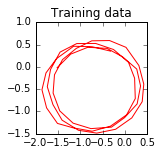

In [20]:
r_ = strokes[10:,:]
r_ = np.cumsum(r_, axis=0)

plt.figure(figsize=(2,2))
plt.plot(r_[:,0], r_[:,1],'r-')
plt.title('Training data')